# Module 7 Lab 3 - Clustering using a Hierarchical Approach
The hierarchical clustering algorithm takes a bottom up approach to creating clusters.  Records are paired together based on minimizing an affinity measure (distance function), which can be specified.  These pairs are then iteratively linked up a tree-like path until at the top you have one master linkage.  This concept is easily visualized using a dendrogram, which we will create.

The self-evident way in which this algorithm can be visualized makes it an appealing choice for presenting the results of clustering to an audience that is not familiar with the concept.  In the healthcare space, dendrograms have been used for displaying classification such as for bacteria, which makes them a natural fit in the healthcare space.

<img src="../resources/bacteria_dendrogram.png"/>


In [1]:
from sklearn import datasets as d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

b = d.load_diabetes()

data = pd.DataFrame(b.data, columns = b.feature_names)
data.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


We will define a utility function (from [here](https://github.com/scikit-learn/scikit-learn/blob/70cf4a676caa2d2dad2e3f6e4478d64bcb0506f7/examples/cluster/plot_hierarchical_clustering_dendrogram.py)) that will create the dendrogram plot using the output from sklearn.

In [2]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):

    # Children of hierarchical clustering
    children = model.children_

    # Distances between each pair of children
    # Since we don't have this information, we can use a uniform one for plotting
    distance = np.arange(children.shape[0])

    # The number of observations contained in each cluster level
    no_of_observations = np.arange(2, children.shape[0]+2)

    # Create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack([children, distance, no_of_observations]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

We will specify 3 clusters as we did for KMeans.  Aside from the number of clusters, we will also specify the linkage criteria we want to use.  The linkage parameter controls the way in which the data points in the clusters are evaluated to compute the distance metric.  Since clusters can (and usually will) contain more than one observation (set of data points), we have to use some aggregated method of choosing our distance metric.  `complete` means we will use the maximum distances between all observations of the two sets.  There are other linkages as well, which you can read about in the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

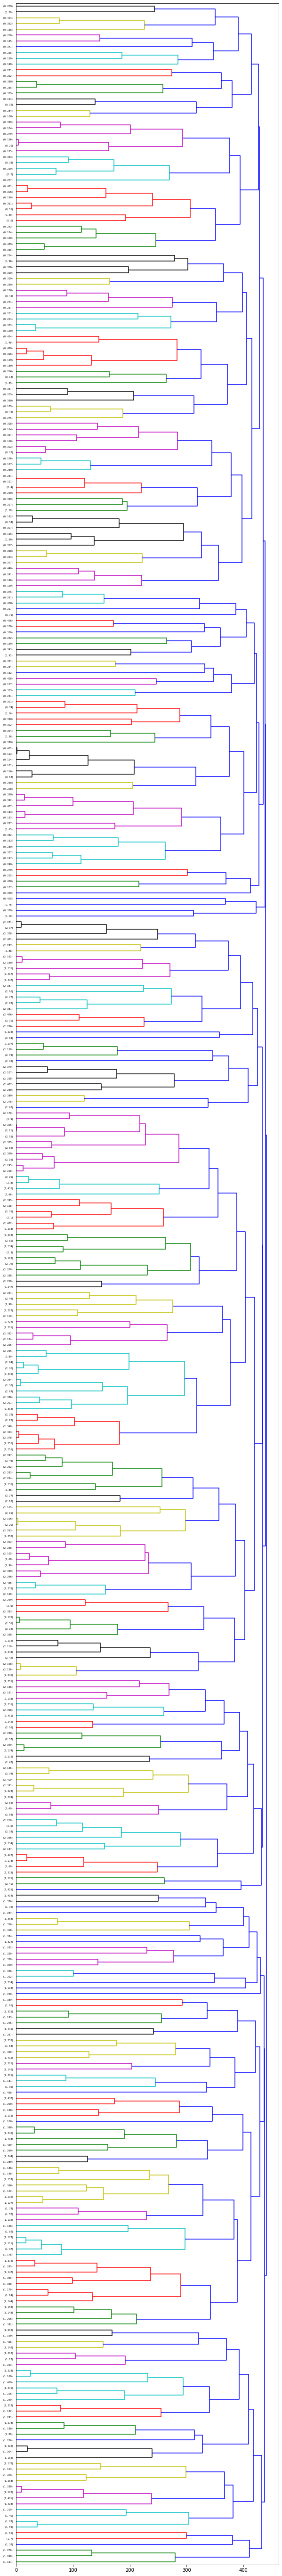

In [3]:
from sklearn.cluster import AgglomerativeClustering

subset=data.iloc[:, 3:5]

model = AgglomerativeClustering(n_clusters=3, linkage='complete').fit(subset)

fig = plt.figure(figsize=(10, 100))
ax1 = fig.add_subplot(111)

# zip the data's row index with the final cluster label for display
plot_dendrogram(model, ax=ax1, orientation='right', labels=list(zip(model.labels_, subset.index)))

plt.show()

In the full dendrogram, each leaf of the tree represents two records paired together based on a closeness measure.  After each record is paired, the the next layer is similarly paired to the next closest branch, and so on until there is only one main branch.

Below we will plot just the first 4 levels of the dendrogram

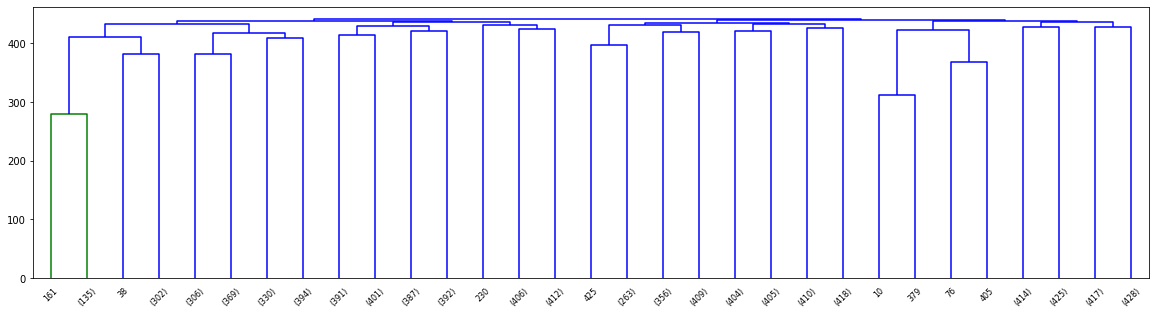

In [4]:
fig = plt.figure(figsize=(20, 5))
ax1 = fig.add_subplot(111)

# here we will plot just the first 4 levels for clarity.
plot_dendrogram(model, ax=ax1, truncate_mode='level', p=4)

plt.show()

Now we'll visualize the clusters on a scatter plot.

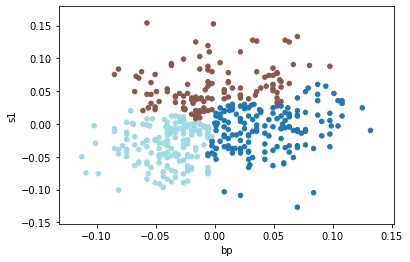

In [5]:
subset.plot.scatter(x=0, y=1, c=model.labels_, colormap='tab20', colorbar=False)

plt.show()

Hierarchical clustering has one main advantage over other types of clustering, and that is its ability to visualize how the resulting clusters were formed (using the dendrogram).

A major disadvantage lies in the algorithm itself.  Besides sharing the need to specify up front the number of clusters with K Means, agglomerative clustering is also a greedy algorithm, meaning that at each step the solution is optimized locally.  If later, up the tree, it could be determined that a better cluster is created by changing some record pairs, it's not possible with Agglomerative.  Contrast that with KMeans, where at each step every record is evaluated and could move to a more appropriate cluster.

## Clustering performance evaluation
We will again use the Calinski-Harabasz score to evaluate the clustering.  Since this number has no upper bound, we cannot know if by itself it is indicative of a good clustering.  Instead we can compare it to clustering performed on the same data set with a different number of clusters and compare the score relative to the different clustering results.  So, let's rerun the clustering using several different values for `n_clusters` that we can then compare using Calinski-Harabasz.


In [6]:
from sklearn import metrics

for i in range(2, 6):
    model = AgglomerativeClustering(n_clusters=i, linkage='complete').fit(subset)
    print(f'clusters = {i}, calinski_harabaz = {round(metrics.calinski_harabaz_score(subset, model.labels_), 3)}')

clusters = 2, calinski_harabaz = 159.448
clusters = 3, calinski_harabaz = 290.329
clusters = 4, calinski_harabaz = 210.98
clusters = 5, calinski_harabaz = 204.598


## Interpretation
The number of clusters with the highest score is 3, so 3 is the best number of clusters (in the range 2 to 5) to choose using the Agglomerative Clustering algorithm, based on the Calinski Harabasz score.  Compare this to the K Means clustering in lab 1, where number of clusters = 3 was also tied for the best using the Silhouette score.  Also compare the score to the DBSCAN result from lab 2.  These scores are much higher, indicating that there is some value in this clustering result over DBSCAN, tempered by the fact that DBSCAN did not cluster a fair number of the data points.